# Eddy-composites

In [1]:
import gcm_filters
import numpy as np
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import seaborn as sns

from datetime import datetime

from dask.diagnostics import ProgressBar

# import cupy as cp
import time as T

import geostats as gs
import filtering as fl

import time as T
import os,sys

import intake

In [2]:
import iris
import iris.analysis as ia

In [3]:
def ifs_to_latlon(ds):
    '''
    Uses the latitude-longitude information encoded in the regular grid IFS output to reconstructed the regular grid
    '''
    return ds.rename({'value':'latlon'}).set_index(latlon=("lat","lon")).unstack("latlon")
def ifs_fix_time_for_monthly_data(ds):
    '''
    Monthly mean data has the time axis encoded incorrectly.
    This function shifts it back by one day
    '''
    return ds.assign_coords(time=ds['time']- pd.Timedelta('1D'))

def get_area(da,mask=False):
    print('Computing grid-box area')
    import iris.analysis as ia
    if 'time' in da.dims:
        da = da.isel(time=0).drop('time')
    d = da.to_iris()
    d.coord('longitude').guess_bounds()
    d.coord('latitude').guess_bounds()

    area_weights = ia.cartography.area_weights(d)
    area = xr.ones_like(da) * area_weights
    if mask:
        area = area.where(~np.isnan(da))
    area = area.rename('area').load()
    area.attrs['long_name'] = 'grid_box_area'
    area.attrs['units'] = 'm^2'
    return area

def print_var(ds,filt=None):
    '''
    Print variables (varname,name) in Dataset. 
    If <filt> is provided, print only those where <filt> is present in the <name> attribute (ds[shortname].attrs['name'])

    Usage: print_var(ds,'wind')
    Output: printout of variables in ds whose name (long name in attributes, not short name to access) contains 'wind', e.g.
        10si  :   10 metre wind speed
        10u  :   10 metre U wind component
        10v  :   10 metre V wind component
    '''
    if filt:
        [print('%10s  :   %s' % (d,ds[d].attrs['name'])) for d in ds if filt.lower() in ds[d].attrs['name'].lower()]
    else:
        [print('%10s  :   %s' % (d,ds[d].attrs['name'])) for d in ds]

## Open and inspect the catalogue

In [4]:
cat = intake.open_catalog('https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml')\
                          ['dkrz']['disk']['model-output']['ifs-amip']

In [5]:
ds_obs_2d_6h = ifs_to_latlon(cat['amip-hist-obs.atmos.gr025']['2D_6h_0.25deg'].to_dask())
ds_lr_2d_6h  = ifs_to_latlon(cat['amip-hist-obs-lr30.atmos.gr025']['2D_6h_0.25deg'].to_dask())

In [20]:
def nin(x,a,b):
    if x>a and x<b:
        return True
    else:
        return False
    
def get_snap_on_eddy(ds,obs,dlon=2.5,dlat=2.5,res=0.25):
    loncen,latcen,time,track = obs.longitude,obs.latitude,obs.time,obs.track
    npts=int(dlon/res)
    lonmin,lonmax = loncen-dlon , loncen+dlon
    latmin,latmax = latcen-dlat , latcen+dlat

    if nin(lonmin,0,360) and nin(lonmax,0,360):
        dsii = ds.sel( 
            time=time,
            lon=slice(lonmin,lonmax),
            lat=slice(latmin,latmax)
        )
    elif lonmin < 0 and lonmax < 0:
        dsii = ds.sel( 
            time=time,
            lon=slice(lonmin+360,lonmax+360),
            lat=slice(latmin,latmax)
        )
    elif lonmin < 0:
        dsii = xr.concat(
            [
                ds.sel( 
                    time=time,
                    lon=slice(360+lonmin,360),
                    lat=slice(latmin,latmax)),
                ds.sel( 
                    time=time,
                    lon=slice(0,lonmax),
                    lat=slice(latmin,latmax))
            ],
            dim='lon'
        )
    elif lonmax > 360:
        dsii = xr.concat(
            [
                ds.sel( 
                    time=time,
                    lon=slice(lonmin,360),
                    lat=slice(latmin,latmax)),
                ds.sel( 
                    time=time,
                    lon=slice(0,lonmax-360),
                    lat=slice(latmin,latmax))
            ],
            dim='lon'
        )
    else:
        sys.exit('This should not happen')

    if dsii.lat.size > 2*npts:
        dsii = dsii.isel(lat=slice(npts))
    if dsii.lon.size > 2*npts:
        dsii = dsii.isel(lon=slice(npts))

    dsii = dsii.assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)
    dsii['longitude'] = loncen
    dsii['latitude'] = latcen
    dsii['track'] = track

    return dsii

In [27]:
def setup_filter(ds, varname, bnds):
    '''
    Setup filter based on <varname> in ds, limited to geographical bnds
    '''
    ds = ds[[varname]].sel(bnds)
    
    ds = fl.define_grid_metrics(ds)
    
    area = gs.get_area(ds[varname])
    
    wetmask_gl = xr.where(np.isnan(ds[varname].isel(time=0)) ,0,1).load()
    # Set mask to zero at southern (irrelevant - Antarctica) and northern (Arctic) boundary to prevent "outflow" of information
    wetmask_gl[0,:] = 0
    wetmask_gl[-1,:] = 0
    # wetmask_gl[:,0] = 0
    # wetmask_gl[:,-1] = 0

    # ======================
    # ROSSBY-RADIUS BASED FILTERING
    # ======================
    LR_gl = xr.open_dataarray('/home/b/b382473/LR_filtered_1degree_r1440x721.nc').sel(bnds)

    # factor 30, (300-1500 km)
    LRfactor = 30
    LRmax = 1500

    # small: factor 5 (50-250 km)
    # LRfactor = 5
    # LRmax = 250
    # large: factor 90 (900-4500 km)
    # LRfactor = 90
    # LRmax = 4500
    # medium: factor 12 (120-600 km)
    # LRfactor = 12
    # LRmax = 600

    LRmin = 10 # set minimum length to 10
    LR_min_max30_gl = xr.where(LR_gl<LRmin,LRmin,LR_gl)
    LR_min_max30_gl = xr.where(LR_min_max30_gl*LRfactor>LRmax,LRmax,LR_min_max30_gl*LRfactor) # 30 x rossby radius, capped at 1500 km
    # path_filterout = '/home/neam/01_SST_VAR/analysis/LR_filtered_1degree_LRmin_%i_LRmax_%i_LRfactor_%i.nc' % (LRmin,LRmax,LRfactor)
    # if not os.path.exists(path_filterout):
    #     LR_min_max30_gl.to_netcdf(path_filterout)

    # L_max = LR.max().values
    L_max_gl = LR_min_max30_gl.max().values
    filter_scale = L_max_gl
    kappa_min_max30_gl = LR_min_max30_gl**2 / L_max_gl**2

    kappa_min_max30_gl = kappa_min_max30_gl.chunk({'lat': len(ds.lat), 'lon': len(ds.lon)}) # 1 chunk

    kappa_w = kappa_min_max30_gl.copy()
    # kappa_w_gpu.data = kappa_w_gpu.data.map_blocks(cp.asarray)
    kappa_s = kappa_min_max30_gl.copy()
    # kappa_s_gpu.data = kappa_s_gpu.data.map_blocks(cp.asarray)

    
    dxw = ds.dxc.rename({'lon_g':'lon'}).assign_coords(lon=ds.lon).rename('dxw')#.sel(lat=slice(-60,60))
    dyw = ds.dyg.rename({'lon_g':'lon'}).assign_coords(lon=ds.lon).rename('dyw')#.sel(lat=slice(-60,60))
    dxs = ds.dxg.rename({'lat_g':'lat'}).assign_coords(lat=ds.lat).rename('dxs')#.sel(lat=slice(-60,60))
    dys = ds.dyc.rename({'lat_g':'lat'}).assign_coords(lat=ds.lat).rename('dys')#.sel(lat=slice(-60,60))

    dx_min = min(
        dxw.min(),
        dyw.min(),
        dxs.min(),
        dys.min()).values

    wet_mask = wetmask_gl.drop('time').chunk({'lat': len(ds.lat), 'lon': len(ds.lon)})  # 1 chunk
    area = area.chunk({'lat': len(ds.lat), 'lon': len(ds.lon)})  # 1 chunk
    dxw = dxw.chunk({'lat': len(ds.lat), 'lon': len(ds.lon)}) # 1 chunk
    dyw = dyw.chunk({'lat': len(ds.lat), 'lon': len(ds.lon)}) # 1 chunk
    dxs = dxs.chunk({'lat': len(ds.lat), 'lon': len(ds.lon)}) # 1 chunk
    dys = dys.chunk({'lat': len(ds.lat), 'lon': len(ds.lon)}) # 1 chunk

    field = ds[varname].where(wet_mask)
    field = field.chunk({'lat': len(ds.lat), 'lon': len(ds.lon)})  # 1 chunk

    specs = dict(
        filter_scale=filter_scale * 1e3,
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    )

    filter_cpu = gcm_filters.Filter(grid_vars={
        'area': area,
        'wet_mask': wet_mask,
        'dxw': dxw,
        'dyw': dyw,
        'dxs': dxs,
        'dys': dys,
        'kappa_w': kappa_w,
        'kappa_s': kappa_s,
        }, **specs)
    print('Filter: ',filter_cpu)
    return filter_cpu


def filter_data(filter_obj, ds, load=False):
    fields_filtered = filter_obj.apply(
        ds, dims=['lat', 'lon'])
    if load:
        with ProgressBar():
            fields_filtered.load()
    return fields_filtered

def get_tracks(kind,source='AVISO'):
    if source=='AVISO':
        catobs = intake.open_catalog('https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml')\
                                  ['dkrz']['disk']['observations']

        tracks = catobs['AVISO']['eddy-tracks'][kind].to_dask()
        tracks['time'].values = pd.to_datetime(tracks.time)

        tracks['obs'] = np.arange(tracks['obs'].size)

        tracks['year'] = tracks['time.year']
        return tracks
        
def composite_highpass(ds,tracks,ds_filtered=None,dlon=2.5,dlat=2.5,res=0.25,load=False):
    comps_fields_hp = []
    for n in range(tracks.obs.size):
        try:
            if ds_filtered:
                tti = get_snap_on_eddy(
                    (
                        ds
                        - ds_filtered
                    ),
                    tracks.isel(obs=n),
                    dlon=dlon,dlat=dlat,res=res)#.drop(['lat_g','lon_g','bnds'])
            else:
                tti = get_snap_on_eddy(
                    ds,
                    tracks.isel(obs=n),
                    dlon=dlon,dlat=dlat,res=res)#.drop(['lat_g','lon_g','bnds'])
        except (KeyError,ValueError):
            continue
        comps_fields_hp.append(tti)
    comps_fields_hp = xr.concat(
        comps_fields_hp,
        dim='obs'
    )
    if load:
        with ProgressBar():
            comps_fields_hp.load()

    return comps_fields_hp

In [22]:
def da_values_in_list(da,vallist):
    '''
    Takes a DataArray <da> and a list of values <vallist>
    Return a DataArray of size <da.size> with value True if the value is in vallist and False otherwise.
    Makes possible to use .sel on multiple entries
    '''
    N = len(vallist)
    if len(vallist) == 0:
        raise KeyError("Empty list!")
    elif len(vallist) == 1:
        return da == vallist[0]
    else:
        outs = (da == vallist[0])
        for i in range(1,N):
            ival = vallist[i]
            outs = outs | (da == vallist[i])
    return outs
        

In [23]:
def da_values_in_timeslice(da,tslice):
    '''
    Takes a DataArray <da> of timestamps and a 2-item list of timestamps
    Return a DataArray of size <da.size> with value True if the value is (>= vallist[0] and < vallist[1]) and False otherwise.
    Makes possible to use .sel on multiple entries
    '''
    return (da >= tslice[0]) & (da < tslice[1])

In [24]:
def da_values_in_timeslice2(da,tslice):
    '''
    Takes a DataArray <da> of timestamps and a 2-item list of timestamps
    Return a DataArray of size <da.size> with value True if the value is (>= vallist[0] and < vallist[1]) and False otherwise.
    Makes possible to use .sel on multiple entries
    '''
    return (da >= tslice.start) & (da <= tslice.stop)

## with filtering

In [13]:
t0 = T.time()

In [14]:
ds0 = ifs_to_latlon(cat['amip-hist-obs.atmos.gr025']['2D_6h_0.25deg'].to_dask())

In [15]:
bnds = dict(lat=slice(-85,85))
timesel = dict(time=
        # '2010-02-02 00:00'
    slice(
        '2010-02-01 00:00',
        '2010-02-10 00:00'
    )
)
if isinstance(timesel['time'],str):
    timesel = dict(time=slice(timesel,timesel))
# if isinstance(timesel['time'],slice):
#     tvals=pd.date_range(timesel['time'].start,timesel['time'].stop,freq='1D')
# elif isinstance(timesel['time'],str):
#     tvals=pd.date_range(timesel['time'],freq='1H',periods=2)

dlon=2.5
dlat=2.5
res=0.25
load = False
kind = 'anticyclonic'
hour = 0 #None # specify hour of day to be selected. None if using all of them
varnames = ['sst','2t','tp','slhf','sshf','str','ssr','tcc']

In [16]:
ds = ds0[varnames].sel(bnds).sel(timesel)
if hour is not None:
    ds = ds.sel(time=ds['time.hour'] == hour)

In [17]:
tracks0 = get_tracks(kind,source='AVISO')
# tracks.sel(obs=tracks[['time']].swap_dims({'obs':'time'}).sortby('time').loc[ dict(time=slice("2011-01-01", "2011-01-02")) ].swap_dims({'time':'obs'}).sortby('obs').obs)
tracks = tracks0.sel(obs=tracks0[['time']].swap_dims({'obs':'time'}).sortby('time').loc[ timesel ].swap_dims({'time':'obs'}).sortby('obs').obs)

In [18]:
np.unique(tracks['time'].values)

array(['2010-02-01T00:00:00.000000000', '2010-02-02T00:00:00.000000000',
       '2010-02-03T00:00:00.000000000', '2010-02-04T00:00:00.000000000',
       '2010-02-05T00:00:00.000000000', '2010-02-06T00:00:00.000000000',
       '2010-02-07T00:00:00.000000000', '2010-02-08T00:00:00.000000000',
       '2010-02-09T00:00:00.000000000', '2010-02-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [19]:
# tracks = tracks.sel(obs=np.logical_and(tracks['time.year']==2010,tracks['time.month']==2))
# tracks = tracks.sel(obs=tracks['time.day']==2)

In [20]:
filter_obj = setup_filter(ds, 'sst', bnds)

/work/bk1377/b382473/conda/envs/science39/lib/python3.9/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/work/bk1377/b382473/conda/envs/science39/lib/python3.9/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


Computing grid-box area
Filter:  Filter(filter_scale=1500000.0, dx_min=array(2361.08780416), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=699, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)


In [21]:
ds_filt = filter_data(filter_obj, ds, load=load)

In [23]:
ds_comps = composite_highpass(ds,
                              tracks,
                              ds_filtered=ds_filt,
                              dlon=dlon,dlat=dlat,res=res,load=load)

In [24]:
with ProgressBar():
    ds_comps.load()

[                                        ] | 0% Completed | 36.99 s

IOStream.flush timed out


[                                        ] | 0% Completed | 414.82 s

IOStream.flush timed out


[########################################] | 100% Completed | 54m 51s


In [25]:
tf = T.time()

In [29]:
print('10 days, load=False: Total time: %.1f seconds / %1.f minutes' % ((tf-t0),(tf-t0)/60))

10 days, load=False: Total time: 4438.6 seconds / 74 minutes


In [35]:
print('Estimated cost for 11 years: 4019 days * 74 minutes / 10 days = %.1f minutes / %.1f hours / %.1f days' % (4019*74/10,4019*74/60,4019*74/60/24))
print('GPU speedup for OSTIA filtering: 20x')

Estimated cost for 11 years: 4019 days * 74 minutes / 10 days = 29740.6 minutes / 4956.8 hours / 206.5 days
GPU speedup for OSTIA filtering: 20x


In [51]:
ds_comps.to_netcdf('amip-hist-obs_2010-02-01_2010-02-10_composited_anticyc.nc')

In [39]:
with ProgressBar():
    ds_comps_mean = ds_comps.mean('obs')

Text(0.5, 0.98, 'Composited anti-cyclonic eddied for amip-hist-obs, 2010-02-01 - 2010-02-10\nCompositing on LR30-highpass filtered 00:00 snapshots')

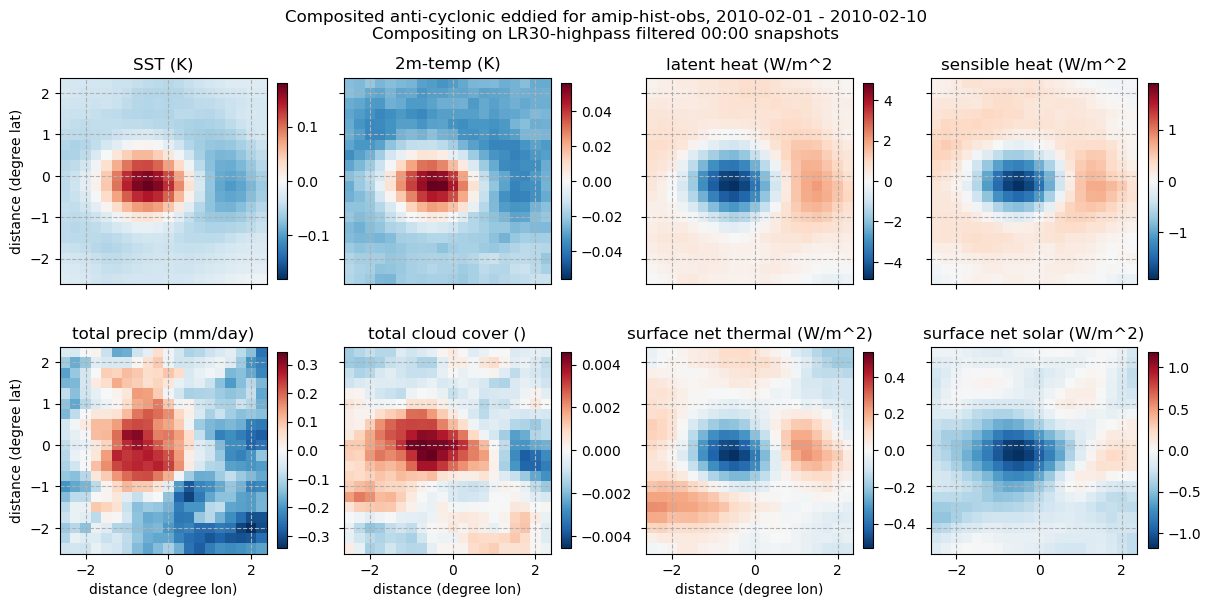

In [47]:
fig, axs = plt.subplots(2,4,sharex=True,sharey=True,constrained_layout=True,figsize=(12,6))
ax = axs.flatten()

ds_comps_mean['sst'].plot(ax=ax[0],cbar_kwargs=dict(shrink=0.75,label=''),add_labels=False)
ax[0].set_title('SST (K)')
ds_comps_mean['2t'].plot(ax=ax[0+1],cbar_kwargs=dict(shrink=0.75,label=''),add_labels=False)
ax[0+1].set_title('2m-temp (K)')
(ds_comps_mean['slhf'] / (6*60**2)).plot(ax=ax[1+1],cbar_kwargs=dict(shrink=0.75,label=''),add_labels=False)
ax[1+1].set_title('latent heat (W/m^2')
(ds_comps_mean['sshf'] / (6*60**2)).plot(ax=ax[2+1],cbar_kwargs=dict(shrink=0.75,label=''),add_labels=False)
ax[2+1].set_title('sensible heat (W/m^2')
(ds_comps_mean['tp'] * 4*4000).plot(ax=ax[3+1],cbar_kwargs=dict(shrink=0.75,label=''),add_labels=False)
ax[3+1].set_title('total precip (mm/day)')
ds_comps_mean['tcc'].plot(ax=ax[4+1],cbar_kwargs=dict(shrink=0.75,label=''),add_labels=False)
ax[4+1].set_title('total cloud cover ()')
(ds_comps_mean['str'] / (6*60**2)).plot(ax=ax[5+1],cbar_kwargs=dict(shrink=0.75,label=''),add_labels=False)
ax[5+1].set_title('surface net thermal (W/m^2)')
(ds_comps_mean['ssr'] / (6*60**2)).plot(ax=ax[6+1],cbar_kwargs=dict(shrink=0.75,label=''),add_labels=False)
ax[6+1].set_title('surface net solar (W/m^2)')

[axi.set_aspect('equal') for axi in ax]

[axi.grid(True,linestyle='--') for axi in ax]

ax[0].set_ylabel('distance (degree lat)')
ax[3+1].set_ylabel('distance (degree lat)')
ax[3+1].set_xlabel('distance (degree lon)')
ax[4+1].set_xlabel('distance (degree lon)')
ax[5+1].set_xlabel('distance (degree lon)')

fig.suptitle('Composited anti-cyclonic eddied for amip-hist-obs, 2010-02-01 - 2010-02-10\nCompositing on LR30-highpass filtered 00:00 snapshots')

# fig.savefig('amip-hist-obs_%s_composited_cyc.png' % str(comps_fields_hp.time.values)[:10], dpi=300,bbox_inches='tight')

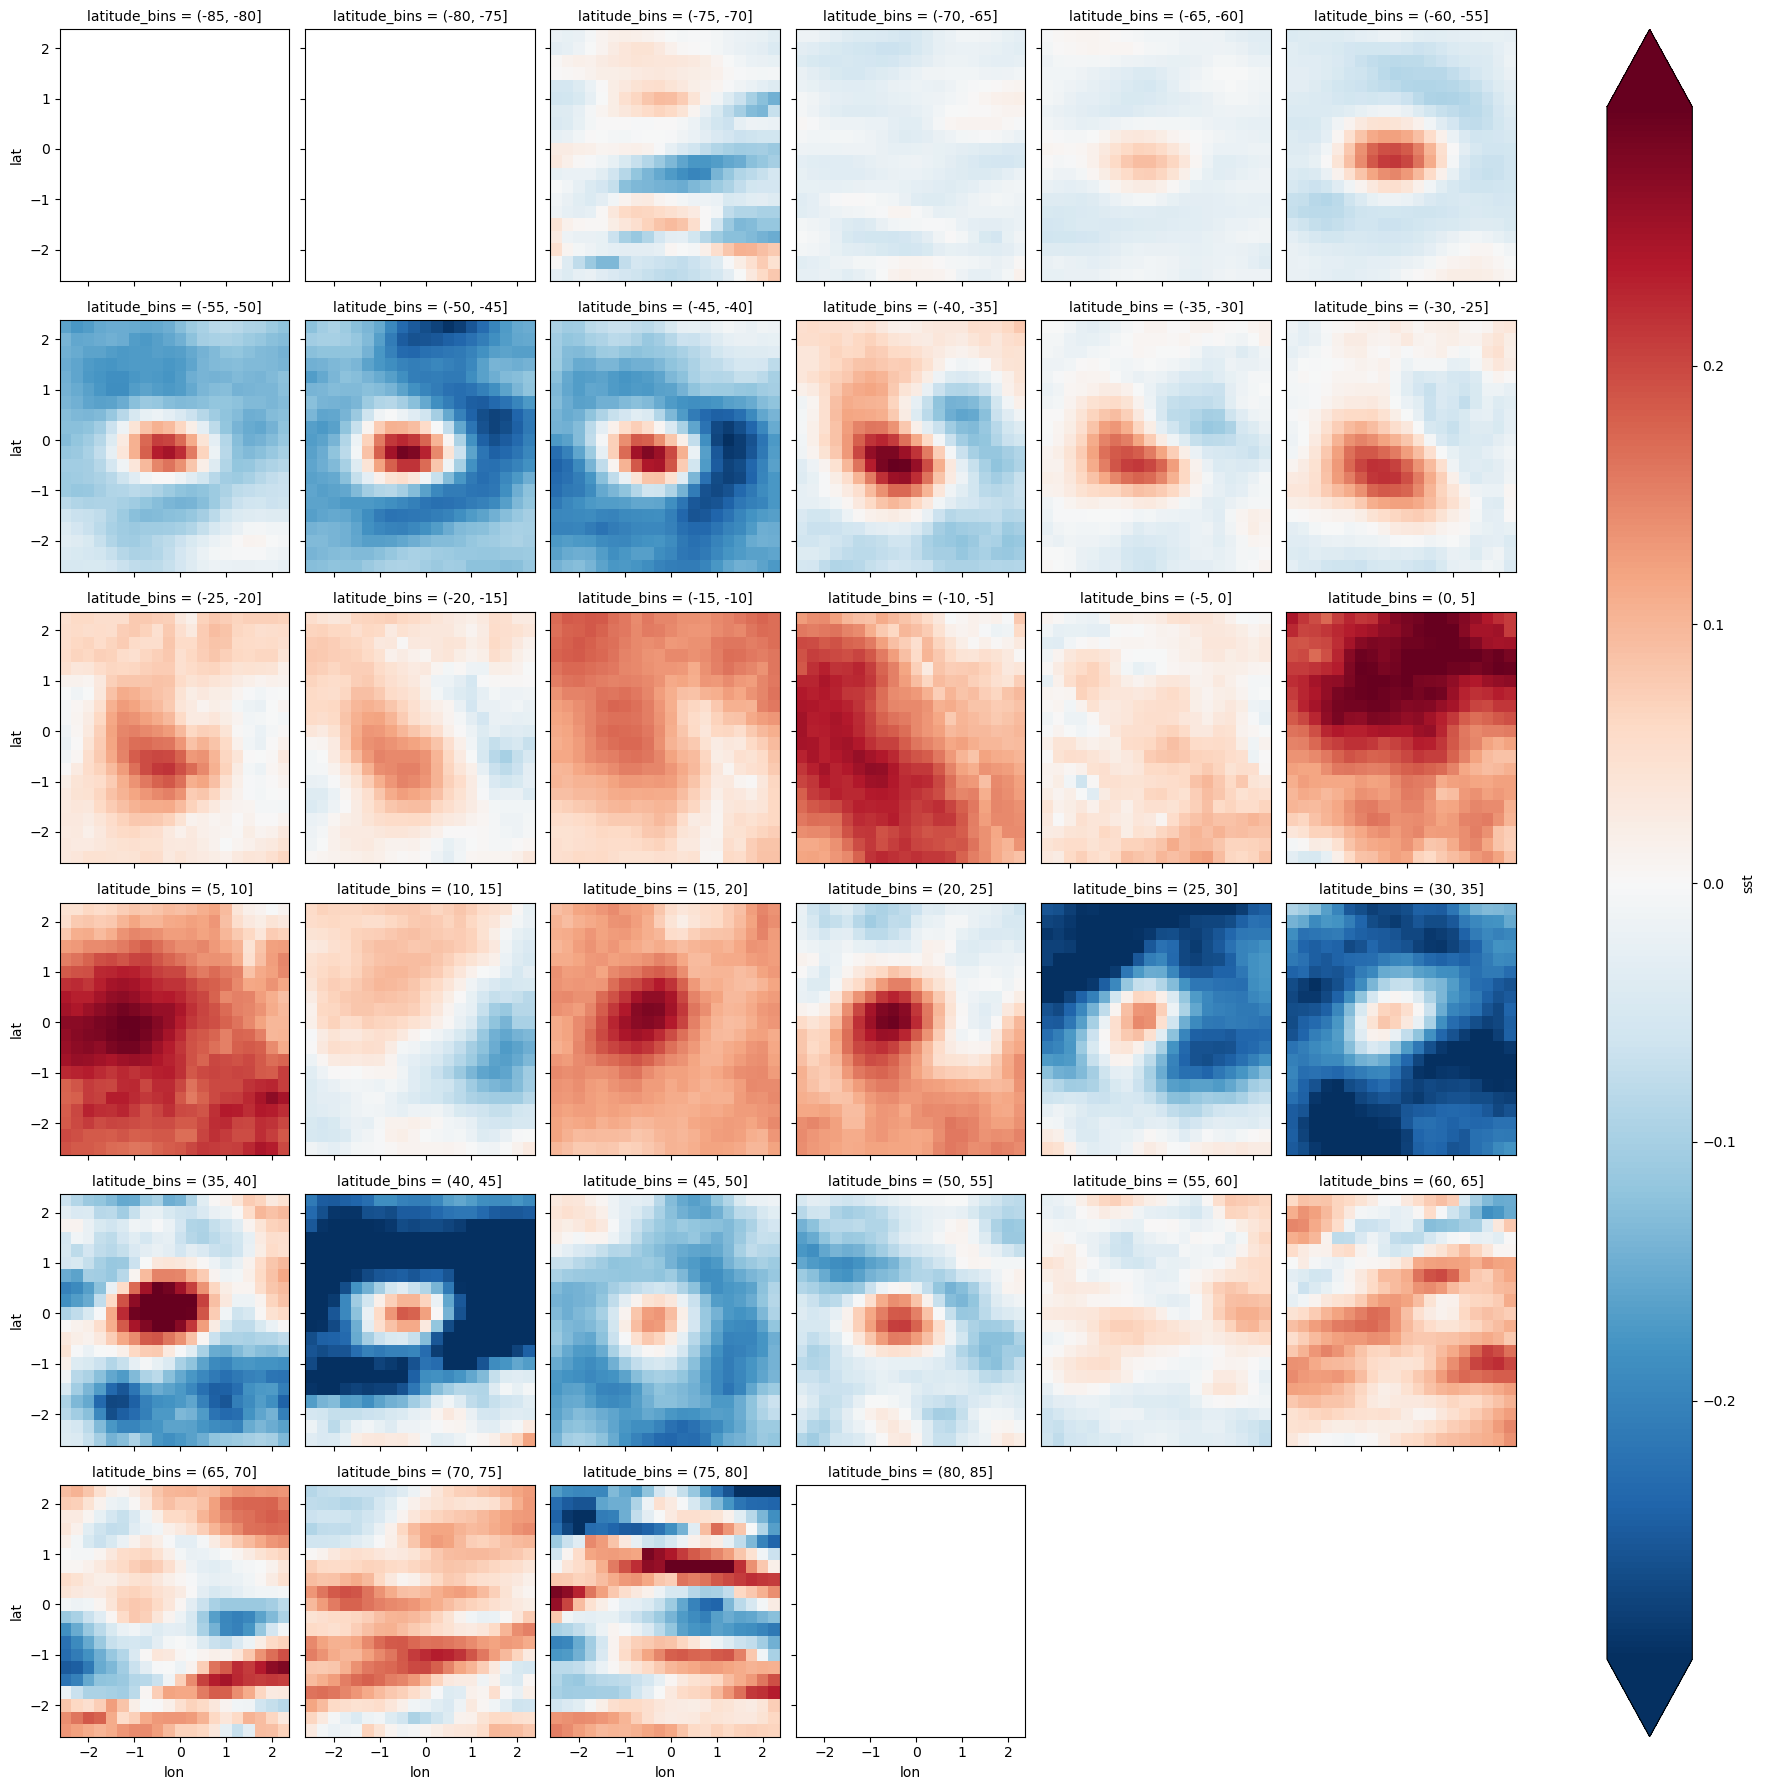

In [54]:
ds_comps.groupby_bins('latitude',np.arange(-85,90,5)).mean().sst.where(
    ds_comps.groupby_bins('latitude',np.arange(-85,90,5)).count().longitude>100
).plot(col='latitude_bins',col_wrap=6,robust=True)